# MARKETING ANALYSIS AND REVENUE PREDICTION

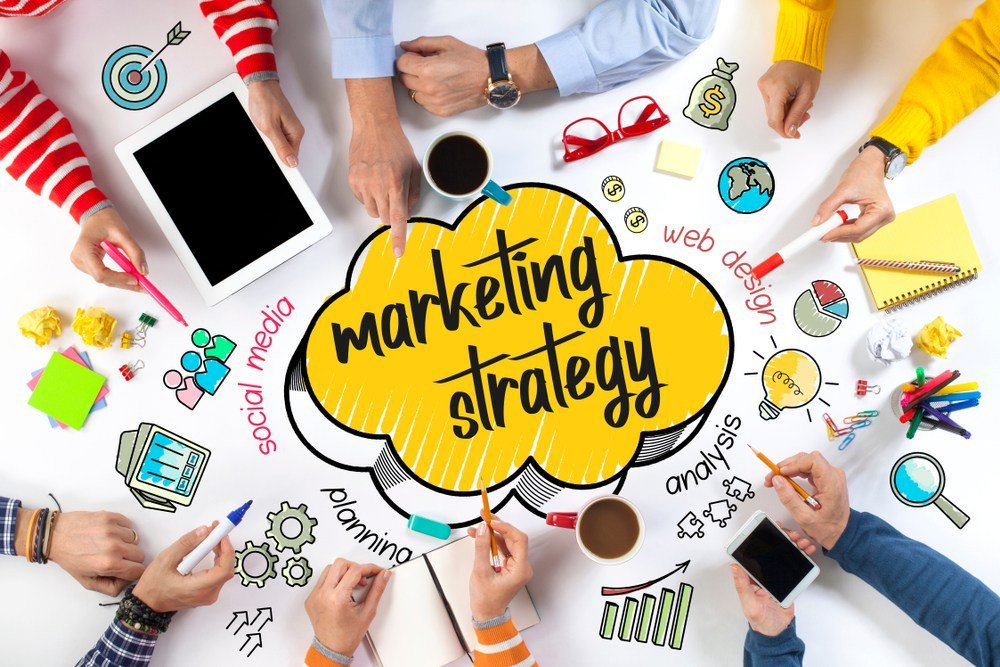

In [1]:
from IPython.display import Image
Image(filename='marketing-stregy.jpg', width=1000, height=1000)

# TABLE OF CONENT

1. Objectives
2. Importing Libraries
3. Data Collection 
4. Exploratory Data Analysis
5. Feature Engineering
6. Modeling 
7. Conclusion

# 1. Objectives 

- To Perform EDA to gain insights into the relationships between advertising budgets and sales revenue. Use techniques such as scatter plots, correlation analysis, and summary statistics to understand the data.

- To build a predictive model that can estimate or predict sales revenue based on the advertising budget allocated to these channels.

# 2. Importing Libraries 

In [1]:
#Importing libraries for data cleaning, processing and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express  as px

#Importing libaries for machine learning
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from statsmodels.formula.api import ols
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor


# 3.  Data Collection

In [14]:
df=pd.read_csv('train.csv')
df.head()

,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,Mega,54.732757
1,13.0,9.237765,2.409567,Mega,46.677897
2,41.0,15.886446,2.913410,Mega,150.177829
3,83.0,30.020028,6.922304,Mega,298.246340
4,15.0,8.437408,1.405998,Micro,56.594181


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572 entries, 0 to 4571
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TV            4562 non-null   float64
 1   Radio         4568 non-null   float64
 2   Social Media  4566 non-null   float64
 3   Influencer    4572 non-null   object 
 4   Sales         4566 non-null   float64
dtypes: float64(4), object(1)
memory usage: 178.7+ KB


**Observation:** 

- The dataframe consists of five features namely Television, radio, Social Media, Influencer and sales.
- The TV promotion budget, Social Media promotion budget, Radio promotions and sales are in millions

**Checking more information about thw data Frame**

In [4]:
print(df.info())
print('')
print('')
print("Missing values:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572 entries, 0 to 4571
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TV            4562 non-null   float64
 1   Radio         4568 non-null   float64
 2   Social Media  4566 non-null   float64
 3   Influencer    4572 non-null   object 
 4   Sales         4566 non-null   float64
dtypes: float64(4), object(1)
memory usage: 178.7+ KB
None


Missing values:
TV              10
Radio            4
Social Media     6
Influencer       0
Sales            6
dtype: int64


**Observation:** 

- The dataframe has 4572 entries, but local television has 10 null values, Radio has 4 null values, social media has  6 null values and sales has 6 null values. 
-

# 4. Exploratory Data Analysis

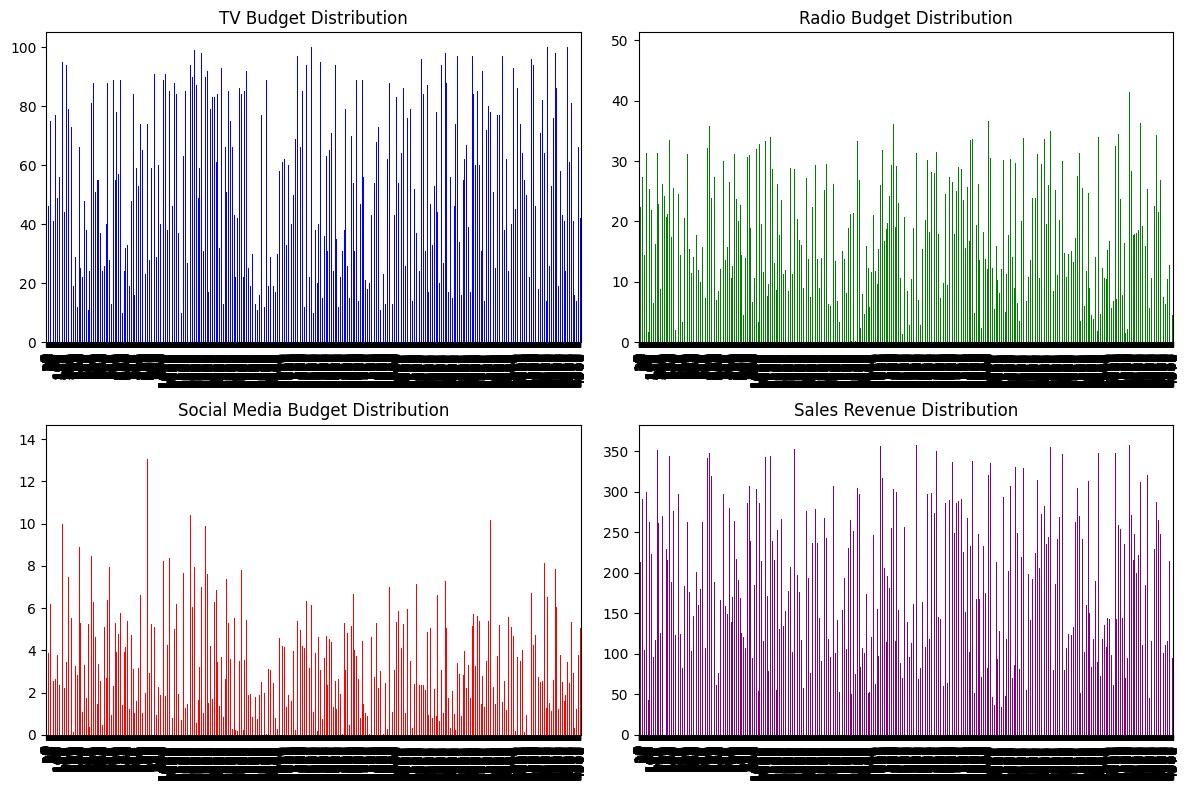

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot histograms for TV, Radio, Social Media, and Sales
df['TV'].plot(kind='bar', ax=axes[0, 0], title='TV Budget Distribution', color='blue')
df['Radio'].plot(kind='bar', ax=axes[0, 1], title='Radio Budget Distribution', color='green')
df['Social Media'].plot(kind='bar', ax=axes[1, 0], title='Social Media Budget Distribution', color='red')
df['Sales'].plot(kind='bar', ax=axes[1, 1], title='Sales Revenue Distribution', color='purple')

# Adjust subplot layout
plt.tight_layout()

# Show the plot
plt.show()


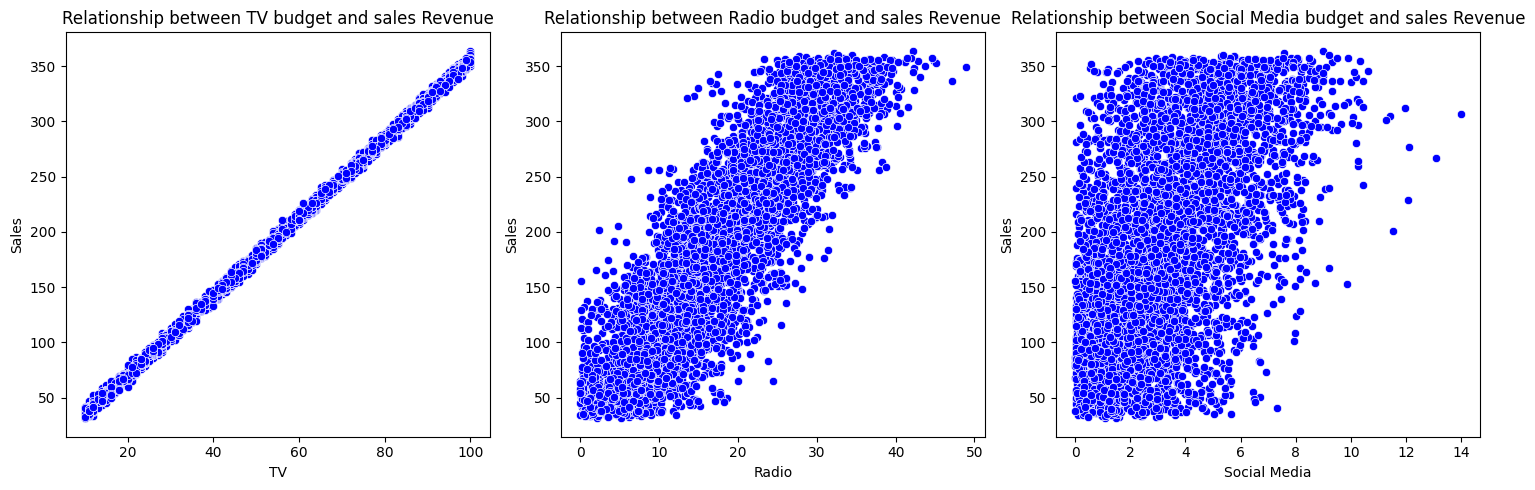

In [8]:
# Setting up the subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

columns=['TV', 'Radio', 'Social Media']
# Creating scatter plots in each subplot
for i, column in enumerate(columns):
    sns.scatterplot(x=df[column], y=df['Sales'], ax=axes[i], color='blue', marker='o')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Sales')
    axes[i].set_title(f'Relationship between {column} budget and sales Revenue')

# Adjusting layout
plt.tight_layout()

# Showing the plots
plt.show()

**Observation**

- Television budget and sales revenue correlates strongly with each other. 
- There is also a visible correlation between Radio and sale revenue. 
- Social media doesnt have a significant correlation with the sales revenue as dipicted by the graph above. 

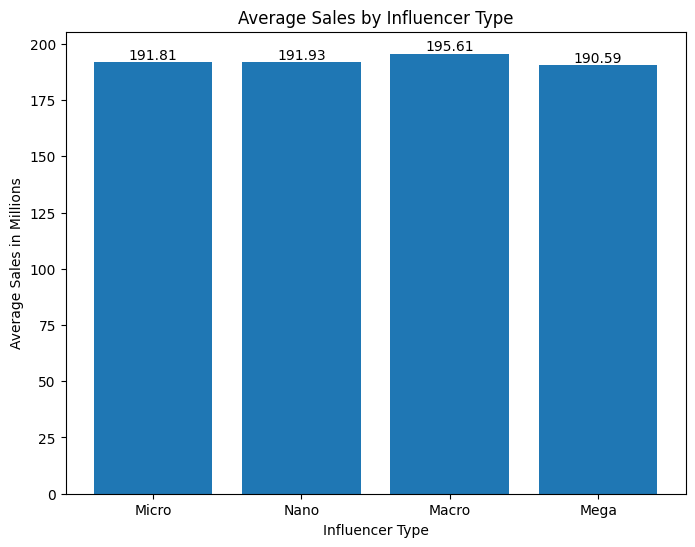

In [6]:

# Filtering data for each event type
Micro = df[df['Influencer'] == 'Micro']
Nano = df[df['Influencer'] == 'Nano']
Macro= df[df['Influencer'] == 'Macro']
Mega = df[df['Influencer'] == 'Mega']

# Calculate revenue sums for each event type
sales = {
    'Micro': Micro['Sales'].mean(),
    'Nano': Nano['Sales'].mean(),
    'Macro': Macro['Sales'].mean(),
    'Mega': Mega['Sales'].mean()
}

# Plotting the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(sales.keys(), sales.values())

# Adding the values on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, '%.2f' % height, ha='center', va='bottom')

# Title and labels
plt.title('Average Sales by Influencer Type')
plt.xlabel('Influencer Type')
plt.ylabel('Average Sales in Millions')

# Displaying the plot
plt.show()

**Observation:**

- Macro Influencer contributes highly to the sales compared to other influencer type on average.  

In [12]:
#Building an encoder
encoder=OrdinalEncoder()
#Applying an encoder to the data
df[['Influencer']]=encoder.fit_transform(df[['Influencer']])
Df=df

<Axes: >

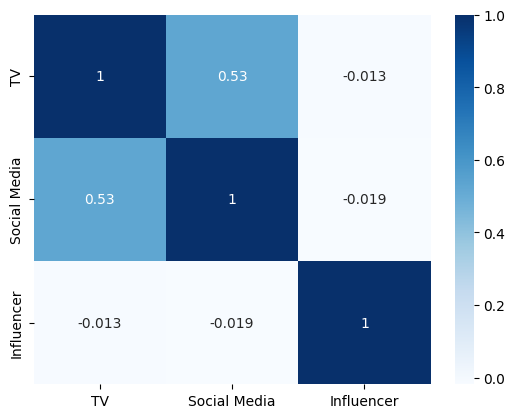

In [13]:
#Heatmap of the numeric values
sns.heatmap((df).corr(),cmap="Blues", annot=True)

**Observation**

- Television and sales has Perfect positive correlation each other. 
-  Both Television and Sales also correlates positively with radio. Thus, to avoid multicolinearity, Radio will not be part of the model. 

# 5. Feature Engineering

**Dropping rows with Null values**




In [9]:
df=df.dropna()
df.isnull().sum()

TV              0
Radio           0
Social Media    0
Influencer      0
Sales           0
dtype: int64

**Seperating the predictors and response variables**

In [11]:
y=df['Sales']
df.drop(columns=['Sales','Radio'], inplace=True)
df.head()

,TV,Social Media,Influencer
0,16.0,2.907983,Mega
1,13.0,2.409567,Mega
2,41.0,2.913410,Mega
3,83.0,6.922304,Mega
4,15.0,1.405998,Micro


**Standardization of Predictors**

In [11]:
st=StandardScaler()
x=st.fit_transform(df)

**Spliting the data into training and testing data**

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 6. Modeling

**Building Different Models**

In [13]:
#Linear Regression
lr= LinearRegression()
#Lasso Regression
lsr=Lasso()
#Ridge Regression
rr= Ridge(alpha=0.1)
#Support Vector Machine
sr=SVR(kernel='rbf', C=1000)
#Decision Tree
dtr=DecisionTreeRegressor(max_depth=7, random_state=42)
#Random Forest Regressor
rfr = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)

**Fitting different model to training data**

In [14]:
#Linear Regression
lr.fit(x_train,y_train)
#Ridge Regression
lsr.fit(x_train,y_train)
#Ridge Regression
rr.fit(x_train,y_train)
#Support Vector Machine
sr.fit(x_train, y_train)
#Decision Tree
dtr.fit(x_train,y_train)
#Random Forest
rfr.fit(x_train,y_train)

RandomForestRegressor(max_depth=5, n_estimators=50, random_state=42)

**Predicting on the training data**

In [15]:
#Linear Regression
lr_y_train = lr.predict(x_train)
#Lasso Regression
lsr_y_train = lsr.predict(x_train)
#Ridge Regression
rr_y_train = rr.predict(x_train)
#Support Vector Machine
sr_y_train = sr.predict(x_train)
#Decision Tree
dtr_y_train = dtr.predict(x_train)
#Random Forest
rfr_y_train = rfr.predict(x_train)

**Predicting on the Testing data**

In [16]:
#Linear Regression 
lr_y_testing = lr.predict(x_test)
#Lasso Regression 
lsr_y_testing = lsr.predict(x_test)
#Ridge Regression 
rr_y_testing = rr.predict(x_test)
#Support Vector Machine
sr_y_testing = sr.predict(x_test)
#Decision tree Regression 
dtr_y_testing = dtr.predict(x_test)
#Random Forest Regressor 
rfr_y_testing = rfr.predict(x_test)

**R squared score on Training data**

In [17]:
#Linear Regression
print('Linear Regression:', r2_score(y_train, lr_y_train))
#Lasso Regression
print('Lasso Regression:', r2_score(y_train, lsr_y_train))
#Ridge Regression
print('Ridge Regression:', r2_score(y_train, rr_y_train))
#Support Vector Machine
print('Support Vector Machine: :', r2_score(y_train, sr_y_train))
#Decision Tree
print('Decision Tree:', r2_score(y_train, dtr_y_train))
#Random Forest
print('Random Forest:', r2_score(y_train, rfr_y_train))

Linear Regression: 0.9989911646888614
Lasso Regression: 0.9988768417414116
Ridge Regression: 0.9989911636585097
Support Vector Machine: : 0.9990089879798487
Decision Tree: 0.9990667632570749
Random Forest: 0.9988349261976638


**R Squared score on Testing data**

In [18]:

#Linear Regression
print('Linear Regression:', r2_score(y_test, lr_y_testing))
#Lasso Regression
print('Lasso Regression:', r2_score(y_test, lsr_y_testing))
#Ridge Regression
print('Ridge Regression:', r2_score(y_test, rr_y_testing))
#Support Vector Machine
print('Support Vector Machine:', r2_score(y_test, sr_y_testing))
#Decision Tree
print('Decision Tree:', r2_score(y_test, dtr_y_testing))
#Random Forest
print('Random Forest:', r2_score(y_test, rfr_y_testing))

Linear Regression: 0.9990103459181142
Lasso Regression: 0.9989095560695348
Ridge Regression: 0.9990104365653264
Support Vector Machine: 0.9989623786366602
Decision Tree: 0.9988838607528088
Random Forest: 0.998774128200137


**Root mean squared error on Training data**

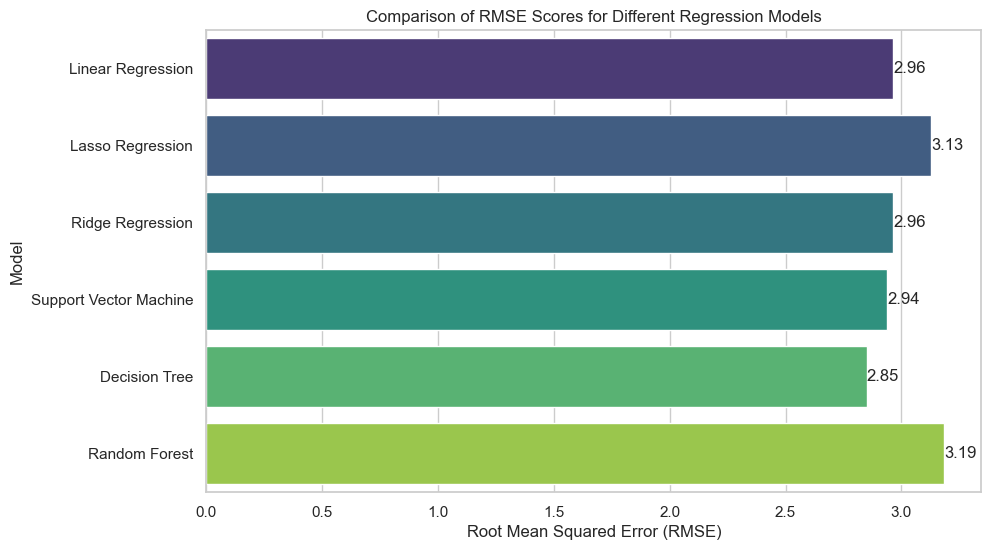

In [19]:
models = ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 
          'Support Vector Machine', 'Decision Tree', 'Random Forest']

rmse_scores = [np.sqrt(mean_squared_error(y_train, lr_y_train)), np.sqrt(mean_squared_error(y_train, lsr_y_train)), np.sqrt(mean_squared_error(y_train, rr_y_train)),np.sqrt(mean_squared_error(y_train, sr_y_train)), np.sqrt(mean_squared_error(y_train, dtr_y_train)), np.sqrt(mean_squared_error(y_train, rfr_y_train))]

data = {'Model': models, 'RMSE': rmse_scores}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
plot = sns.barplot(x='RMSE', y='Model', data=df, palette="viridis")
plt.xlabel('Root Mean Squared Error (RMSE)')
plt.ylabel('Model')
plt.title('Comparison of RMSE Scores for Different Regression Models')

# Annotate bars with RMSE values
for index, value in enumerate(rmse_scores):
    plot.text(value, index, f'{value:.2f}', va='center')

plt.show()

**Observation**
- Root mean squared error is measure of the differences between values predicted by a model  and the values observed. The smaller the value, the better the model. 
- The graph above illustrates that Decision treeis the best model  compared to the other models on predicting on the training data. 

**Root mean squared error on Training data**

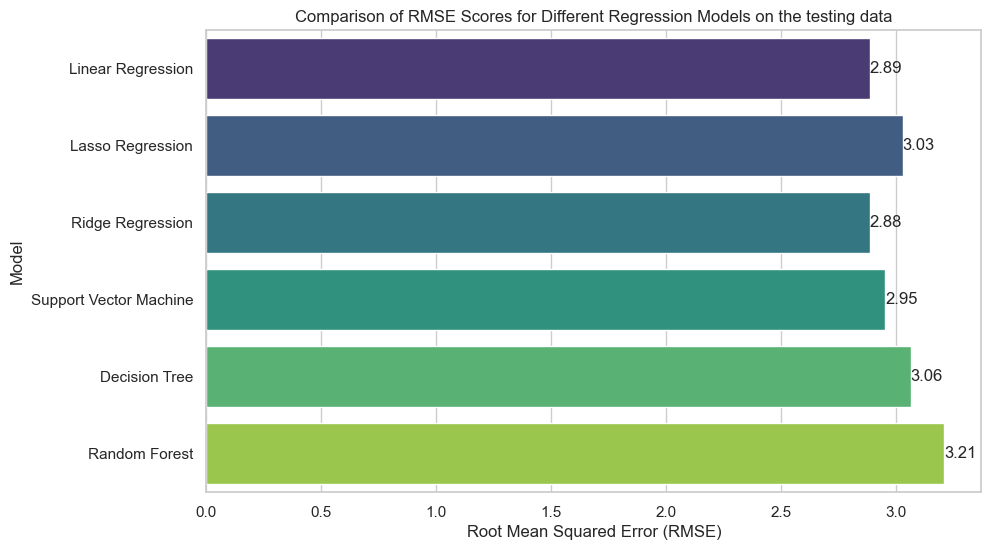

In [20]:
models = ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 
          'Support Vector Machine', 'Decision Tree', 'Random Forest']

rmse_scores = [np.sqrt(mean_squared_error(y_test, lr_y_testing)), np.sqrt(mean_squared_error(y_test, lsr_y_testing)), np.sqrt(mean_squared_error(y_test, rr_y_testing)),np.sqrt(mean_squared_error(y_test, sr_y_testing)), np.sqrt(mean_squared_error(y_test, dtr_y_testing)), np.sqrt(mean_squared_error(y_test, rfr_y_testing))]

data = {'Model': models, 'RMSE': rmse_scores}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
plot = sns.barplot(x='RMSE', y='Model', data=df, palette="viridis")
plt.xlabel('Root Mean Squared Error (RMSE)')
plt.ylabel('Model')
plt.title('Comparison of RMSE Scores for Different Regression Models on the testing data')

# Annotate bars with RMSE values
for index, value in enumerate(rmse_scores):
    plot.text(value, index, f'{value:.2f}', va='center')

plt.show()

**Observation**

- The graph above illustrates that the best model predicting on unseen data is the ridge regression and Linear regression.
- It is important to consider overfitting when choosing the best model. Overfitting is when the machine learning model gives accurate predictions for training data but not for new data.
- From the model used, Support Vector machine has a smaller difference between rmse for training data and testing data. Thus, this is the best model for predicting the sales. 

# 8. Conclusion 